In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip','r')
zip_ref.extractall()
zip_ref.close()

--2022-03-21 07:49:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   155MB/s    in 1.0s    

2022-03-21 07:49:29 (155 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
  print(f'{dirpath}: {len(dirnames)}, {len(filenames)}')

10_food_classes_10_percent: 2, 0
10_food_classes_10_percent/train: 10, 0
10_food_classes_10_percent/train/ramen: 0, 75
10_food_classes_10_percent/train/pizza: 0, 75
10_food_classes_10_percent/train/chicken_curry: 0, 75
10_food_classes_10_percent/train/hamburger: 0, 75
10_food_classes_10_percent/train/grilled_salmon: 0, 75
10_food_classes_10_percent/train/steak: 0, 75
10_food_classes_10_percent/train/ice_cream: 0, 75
10_food_classes_10_percent/train/fried_rice: 0, 75
10_food_classes_10_percent/train/sushi: 0, 75
10_food_classes_10_percent/train/chicken_wings: 0, 75
10_food_classes_10_percent/test: 10, 0
10_food_classes_10_percent/test/ramen: 0, 250
10_food_classes_10_percent/test/pizza: 0, 250
10_food_classes_10_percent/test/chicken_curry: 0, 250
10_food_classes_10_percent/test/hamburger: 0, 250
10_food_classes_10_percent/test/grilled_salmon: 0, 250
10_food_classes_10_percent/test/steak: 0, 250
10_food_classes_10_percent/test/ice_cream: 0, 250
10_food_classes_10_percent/test/fried_rice:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir='10_food_classes_10_percent/train'
test_dir='10_food_classes_10_percent/test'

train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  print(f"saving log files to {log_dir}")
  call_back = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  return call_back

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
def create_model(model_url, num_classes=10):

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  
  model = tf.keras.models.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
resnet_model = create_model(resnet_url, train_data.num_classes)

resnet_model.compile(optimizer = tf.keras.optimizers.Adam(),
                     loss = 'categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet50V2")]
)

saving log files to tensor_hub/resnet50V2/20220321-074606
Epoch 1/5
24/24 [==============================] - 489s 21s/step - loss: 1.9149 - accuracy: 0.3373 - val_loss: 1.2193 - val_accuracy: 0.6152
Epoch 2/5
24/24 [==============================] - 483s 21s/step - loss: 0.8883 - accuracy: 0.7453 - val_loss: 0.8490 - val_accuracy: 0.7324
Epoch 3/5
24/24 [==============================] - 484s 21s/step - loss: 0.6300 - accuracy: 0.8240 - val_loss: 0.7514 - val_accuracy: 0.7628
Epoch 4/5
24/24 [==============================] - 448s 19s/step - loss: 0.4751 - accuracy: 0.8800 - val_loss: 0.7177 - val_accuracy: 0.7756
Epoch 5/5
24/24 [==============================] - 486s 21s/step - loss: 0.3781 - accuracy: 0.9107 - val_loss: 0.6669 - val_accuracy: 0.7864


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  acc = history.history['accuracy']
  loss = history.history['loss']

  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  epochs = range(len(history.history['accuracy']))

  plt.plot(epochs, acc, label='training_acc')
  plt.plot(epochs, val_acc, label='test_acc')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_acc, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

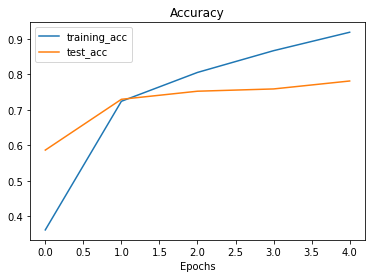

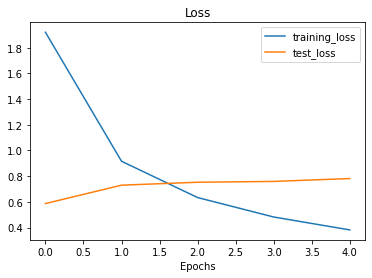

In [ ]:
plot_history(resnet_history)

In [ ]:
efficient_model = create_model(efficientnet_url, train_data.num_classes)

efficient_model.compile(optimizer = tf.keras.optimizers.Adam(),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

efficient_history = efficient_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                experiment_name="efficientnetB0")])

saving log files to tensorflow_hub/efficientnetB0/20220321-081228
Epoch 1/5
24/24 [==============================] - 25s 679ms/step - loss: 1.7840 - accuracy: 0.4747 - val_loss: 1.2553 - val_accuracy: 0.7644
Epoch 2/5
24/24 [==============================] - 15s 634ms/step - loss: 1.0304 - accuracy: 0.7973 - val_loss: 0.8397 - val_accuracy: 0.8344
Epoch 3/5
24/24 [==============================] - 15s 630ms/step - loss: 0.7347 - accuracy: 0.8440 - val_loss: 0.6770 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 15s 632ms/step - loss: 0.5936 - accuracy: 0.8733 - val_loss: 0.5989 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 15s 631ms/step - loss: 0.5016 - accuracy: 0.9013 - val_loss: 0.5467 - val_accuracy: 0.8640


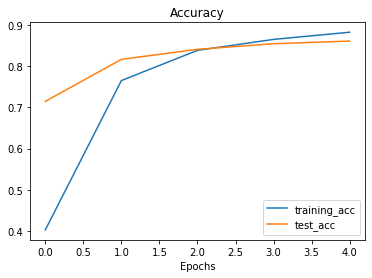

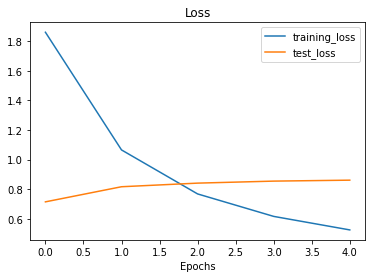

In [ ]:
plot_history(efficient_history)

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Bd9gT8AuQ4CX7Y1zYJ1Ncg/

[2022-03-21T08:21:06] Started scanning logdir.
[2022-03-21T08:21:09] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (9.5 MB)
[2022-03-21T08:21:09] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/Bd9gT8AuQ4CX7Y1zYJ1Ncg/


In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/Bd9gT8AuQ4CX7Y1zYJ1Ncg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   Bd9gT8AuQ4CX7Y1zYJ1Ncg
	Created              2022-03-21 08:21:06 (1 minute ago)
	Updated              2022-03-21 08:21:09 (1 minute ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  9996704
https://tensorboard.dev/experiment/sMUeP36qQpKhyU0V3y5KYA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   sMUeP36qQpKhyU0V3y5KYA
	Created              2022-03-21 08:16:44 (6 minutes ago)
	Updated              2022-03-21 08:16:47 (6 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes 

In [ ]:
!tensorboard dev delete --experiment_id e6snpHMrT4yQ7sJwV4DyaQ

Deleted experiment e6snpHMrT4yQ7sJwV4DyaQ.
